## Name: Erfan Shahabi
## Student ID: 810103166
## DM CA6

##Importing Data

In [1]:
!pip install OGB


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.9 MB/s eta 0:00:00


In [3]:
from ogb.nodeproppred import NodePropPredDataset

dataset = NodePropPredDataset(name = "ogbn-arxiv")

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
graph, label = dataset[0]

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:01<00:00, 80.94it/s]


Extracting dataset/arxiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 5809.29it/s]

Saving...


In [4]:
dataset[0]

({'edge_index': array([[104447,  15858, 107156, ...,  45118,  45118,  45118],
         [ 13091,  47283,  69161, ..., 162473, 162537,  72717]]),
  'edge_feat': None,
  'node_feat': array([[-0.057943, -0.05253 , -0.072603, ...,  0.173364, -0.172796,
          -0.140059],
         [-0.1245  , -0.070665, -0.325202, ...,  0.068524, -0.372111,
          -0.301036],
         [-0.080242, -0.023328, -0.183787, ...,  0.109919,  0.117589,
          -0.139883],
         ...,
         [-0.22053 , -0.036568, -0.402199, ...,  0.11336 , -0.161393,
          -0.145171],
         [-0.138236,  0.040885, -0.251811, ..., -0.08929 , -0.041253,
          -0.376132],
         [-0.029875,  0.268417, -0.161124, ...,  0.120807,  0.077647,
          -0.091018]], dtype=float32),
  'node_year': array([[2013],
         [2015],
         [2014],
         ...,
         [2020],
         [2020],
         [2020]]),
  'num_nodes': 169343},
 array([[ 4],
        [ 5],
        [28],
        ...,
        [10],
        [ 4],
 

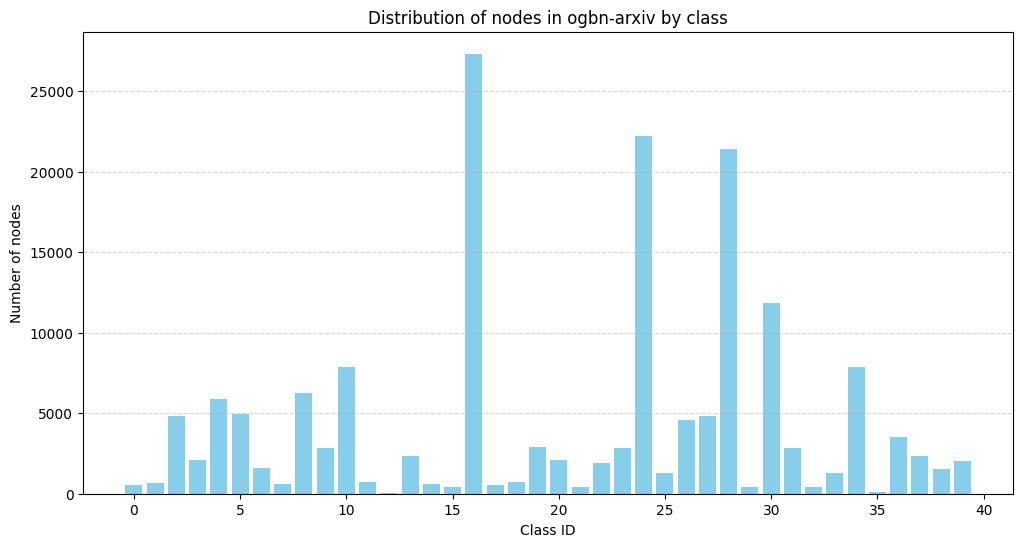

In [5]:
import matplotlib.pyplot as plt
import numpy as np

labels = label.squeeze()
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(12, 6))
plt.bar(unique, counts, color='skyblue')
plt.xlabel("Class ID")
plt.ylabel("Number of nodes")
plt.title("Distribution of nodes in ogbn-arxiv by class")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

## Model Structure

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear, Module
import torch.nn as nn

class GCNEncoder(Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [7]:
class MultiTaskModel(Module):
    def __init__(self, in_dim, hidden_dim, embed_dim, num_classes, dropout=0.5):
        super().__init__()
        self.encoder = GCNEncoder(in_dim, hidden_dim, embed_dim, dropout)
        self.node_classifier = Linear(embed_dim, num_classes)
        self.link_predictor = Linear(embed_dim * 2, 1)

    def forward(self, x, edge_index, node_pairs=None):
        # node embeddings
        z = self.encoder(x, edge_index)

        # node classification head
        node_logits = self.node_classifier(z)

        # link prediction head
        if node_pairs is not None:
            src, dst = node_pairs
            edge_repr = torch.cat([z[src], z[dst]], dim=1)
            link_logits = self.link_predictor(edge_repr)
        else:
            link_logits = None

        return node_logits, link_logits, z



In [10]:
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
import torch
def compute_class_weights(labels, train_idx, num_classes=None):
    import torch

    if isinstance(labels, np.ndarray):
        labels = torch.from_numpy(labels)

    if labels.dim() == 2:
        labels = labels.squeeze()

    labels_train = labels[train_idx]

    if num_classes is None:
        num_classes = int(labels_train.max().item()) + 1

    counts = torch.bincount(labels_train, minlength=num_classes)
    weights = 1.0 / (counts.float() + 1e-6)
    weights = weights / weights.sum() * num_classes

    return weights

if isinstance(label, np.ndarray):
    label = torch.from_numpy(label).squeeze()
else:
    label = label.squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label = label.to(device)
train_idx = torch.from_numpy(train_idx).to(device)
class_weights = compute_class_weights(label, train_idx).to(device)
node_loss_fn = CrossEntropyLoss(weight=class_weights)

link_loss_fn = BCEWithLogitsLoss()
def compute_loss(node_logits, link_logits, node_labels, link_labels, alpha=1.0, beta=1.0):
    loss_node = node_loss_fn(node_logits, node_labels)
    loss_link = link_loss_fn(link_logits.squeeze(), link_labels.float())
    return alpha * loss_node + beta * loss_link, loss_node, loss_link

In [11]:
import random

def sample_link_examples(edge_index, num_nodes, num_samples=500):

    edge_list = edge_index.t().tolist()
    pos_edges = random.sample(edge_list, num_samples)
    neg_edges = set()
    while len(neg_edges) < num_samples:
        i, j = random.randint(0, num_nodes-1), random.randint(0, num_nodes-1)
        if [i, j] not in edge_list and i != j:
            neg_edges.add((i, j))
    neg_edges = list(neg_edges)

    all_pairs = pos_edges + neg_edges
    labels = [1] * len(pos_edges) + [0] * len(neg_edges)
    src, dst = zip(*all_pairs)
    return (torch.tensor(src), torch.tensor(dst)), torch.tensor(labels)

In [12]:
def prepare_features(graph, normalize_year=True):
    import torch
    import numpy as np

    node_feat = torch.from_numpy(graph["node_feat"]).float()

    node_year = graph["node_year"].astype(np.float32)
    if normalize_year:
        node_year = (node_year - node_year.mean()) / (node_year.std() + 1e-8)

    node_year = torch.from_numpy(node_year).reshape(-1, 1)

    return torch.cat([node_feat, node_year], dim=1)
x = prepare_features(graph)

In [13]:
in_dim = x.shape[1]
hidden_dim = 128
embed_dim = 64
num_classes = int(label.max().item()) + 1
model = MultiTaskModel(
    in_dim=in_dim,
    hidden_dim=hidden_dim,
    embed_dim=embed_dim,
    num_classes=num_classes,
    dropout=0.5
).to(device)

In [28]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize

model.train()


all_node_losses, all_link_losses = [], []

node_accs, node_precisions, node_recalls, node_f1s, node_aucs = [], [], [], [], []
node_train_accs, node_train_precisions, node_train_recalls, node_train_f1s = [], [], [], []

link_accs, link_precisions, link_recalls, link_f1s, link_aucs = [], [], [], [], []

(src_eval, dst_eval), link_labels_eval = sample_link_examples(edge_index, x.size(0), num_samples=1000)
src_eval, dst_eval, link_labels_eval = src_eval.to(device), dst_eval.to(device), link_labels_eval.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 90

for epoch in range(num_epochs):
    optimizer.zero_grad()

    x = x.to(device)
    edge_index = torch.from_numpy(graph["edge_index"]).long().to(device)
    label = label.to(device).squeeze()
    train_idx = train_idx.to(device)
    valid_idx = valid_idx.to(device)

    (src, dst), link_labels = sample_link_examples(edge_index, x.size(0))
    src, dst, link_labels = src.to(device), dst.to(device), link_labels.to(device)

    #forward
    node_logits, link_logits, _ = model(x, edge_index, node_pairs=(src, dst))

    #Loss
    node_logits_train = node_logits[train_idx]
    node_labels_train = label[train_idx]
    total_loss, node_loss, link_loss = compute_loss(
        node_logits_train, link_logits, node_labels_train, link_labels
    )

    total_loss.backward()
    optimizer.step()

    all_node_losses.append(node_loss.item())
    all_link_losses.append(link_loss.item())


    model.eval()
    with torch.no_grad():
        node_logits_eval, _, _ = model(x, edge_index)

        # Node Classification-validation
        y_pred = node_logits_eval[valid_idx].argmax(dim=1).cpu().numpy()
        y_true = label[valid_idx].cpu().numpy()
        y_proba = node_logits_eval[valid_idx].softmax(dim=1).cpu().numpy()
        y_true_bin = label_binarize(y_true, classes=np.arange(node_logits_eval.shape[1]))

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
        rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
        try:
            auc = roc_auc_score(y_true_bin, y_proba, average="macro", multi_class="ovr")
        except ValueError:
            auc = 0.0

        node_accs.append(acc)
        node_precisions.append(prec)
        node_recalls.append(rec)
        node_f1s.append(f1)
        node_aucs.append(auc)

        #Node Classification-train
        y_pred_train = node_logits_eval[train_idx].argmax(dim=1).cpu().numpy()
        y_true_train = label[train_idx].cpu().numpy()

        acc_train = accuracy_score(y_true_train, y_pred_train)
        prec_train = precision_score(y_true_train, y_pred_train, average="macro", zero_division=0)
        rec_train = recall_score(y_true_train, y_pred_train, average="macro", zero_division=0)
        f1_train = f1_score(y_true_train, y_pred_train, average="macro", zero_division=0)

        node_train_accs.append(acc_train)
        node_train_precisions.append(prec_train)
        node_train_recalls.append(rec_train)
        node_train_f1s.append(f1_train)

        # link prediction
        _, link_logits_eval, _ = model(x, edge_index, node_pairs=(src_eval, dst_eval))
        link_probs = torch.sigmoid(link_logits_eval).squeeze()
        link_preds = (link_probs > 0.5).long()

        acc_link = accuracy_score(link_labels_eval.cpu(), link_preds.cpu())
        prec_link = precision_score(link_labels_eval.cpu(), link_preds.cpu())
        rec_link = recall_score(link_labels_eval.cpu(), link_preds.cpu())
        f1_link = f1_score(link_labels_eval.cpu(), link_preds.cpu())
        auc_link = roc_auc_score(link_labels_eval.cpu(), link_probs.cpu())

        link_accs.append(acc_link)
        link_precisions.append(prec_link)
        link_recalls.append(rec_link)
        link_f1s.append(f1_link)
        link_aucs.append(auc_link)

    model.train()
    print(
          f"Epoch {epoch:02d} | "
          f"Train F1: {f1_train:.4f} | "
          f"Val F1: {f1:.4f} | "
          f"Link F1: {f1_link:.4f} | "
          f"Node Loss: {node_loss.item():.4f} | "
          f"Link Loss: {link_loss.item():.4f}"
          )


pd.DataFrame({
    "epoch": list(range(num_epochs)),
    "val_accuracy": node_accs,
    "val_precision": node_precisions,
    "val_recall": node_recalls,
    "val_f1": node_f1s,
    "val_auc": node_aucs
}).to_csv("validation_metrics.csv", index=False)

pd.DataFrame({
    "epoch": list(range(num_epochs)),
    "train_accuracy": node_train_accs,
    "train_precision": node_train_precisions,
    "train_recall": node_train_recalls,
    "train_f1": node_train_f1s
}).to_csv("training_metrics.csv", index=False)

pd.DataFrame({
    "epoch": list(range(num_epochs)),
    "link_accuracy": link_accs,
    "link_precision": link_precisions,
    "link_recall": link_recalls,
    "link_f1": link_f1s,
    "link_auc": link_aucs
}).to_csv("link_metrics.csv", index=False)

Epoch 00 | Train F1: 0.3124 | Val F1: 0.2439 | Link F1: 0.8014 | Node Loss: 2.1266 | Link Loss: 0.4134
Epoch 01 | Train F1: 0.3399 | Val F1: 0.2821 | Link F1: 0.7233 | Node Loss: 2.1748 | Link Loss: 0.4069
Epoch 02 | Train F1: 0.3859 | Val F1: 0.3196 | Link F1: 0.7968 | Node Loss: 2.1616 | Link Loss: 0.5235
Epoch 03 | Train F1: 0.3786 | Val F1: 0.3121 | Link F1: 0.8041 | Node Loss: 2.0780 | Link Loss: 0.4506
Epoch 04 | Train F1: 0.3559 | Val F1: 0.2849 | Link F1: 0.7810 | Node Loss: 1.9868 | Link Loss: 0.4144
Epoch 05 | Train F1: 0.3477 | Val F1: 0.2782 | Link F1: 0.7738 | Node Loss: 1.9789 | Link Loss: 0.4246
Epoch 06 | Train F1: 0.3491 | Val F1: 0.2810 | Link F1: 0.7819 | Node Loss: 1.9890 | Link Loss: 0.4303
Epoch 07 | Train F1: 0.3503 | Val F1: 0.2857 | Link F1: 0.7943 | Node Loss: 1.9924 | Link Loss: 0.4315
Epoch 08 | Train F1: 0.3528 | Val F1: 0.2856 | Link F1: 0.8023 | Node Loss: 1.9908 | Link Loss: 0.4154
Epoch 09 | Train F1: 0.3540 | Val F1: 0.2862 | Link F1: 0.8030 | Node Los

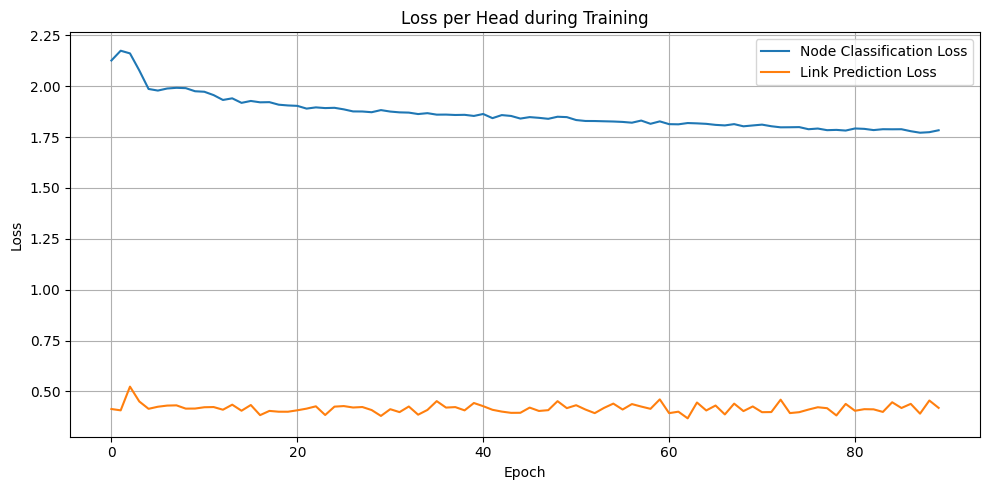

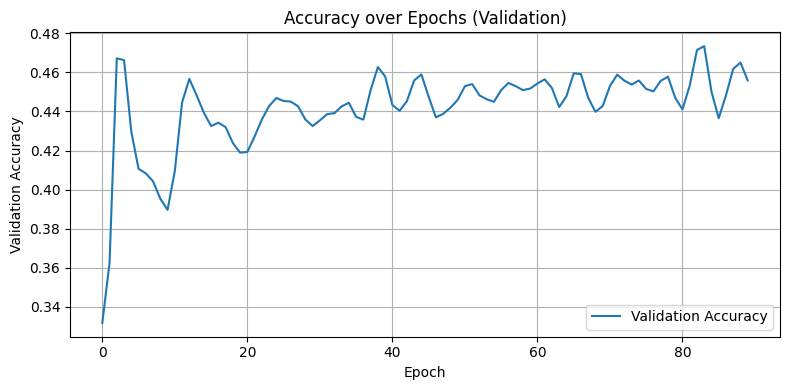

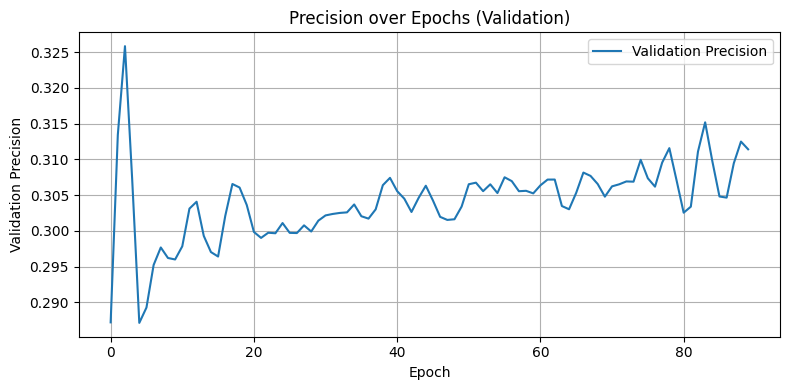

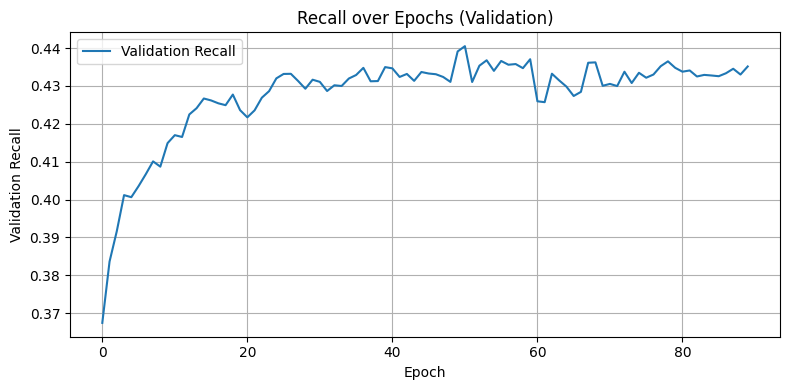

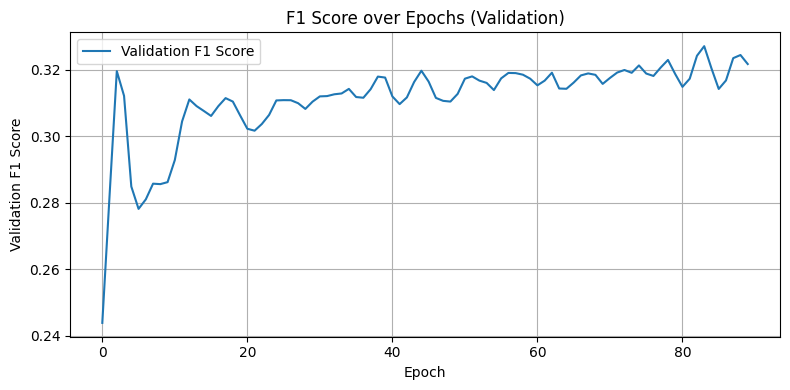

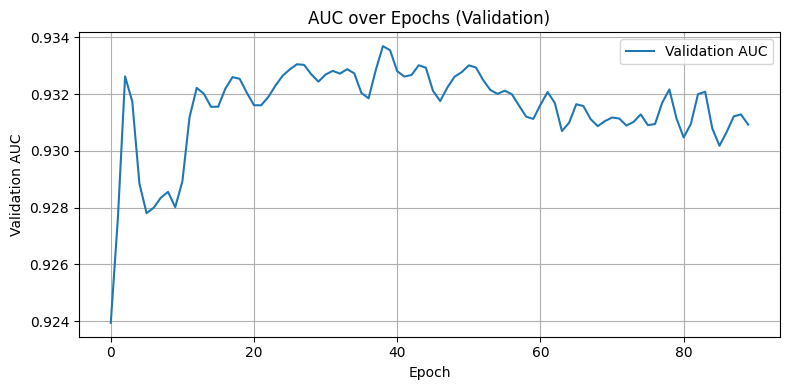

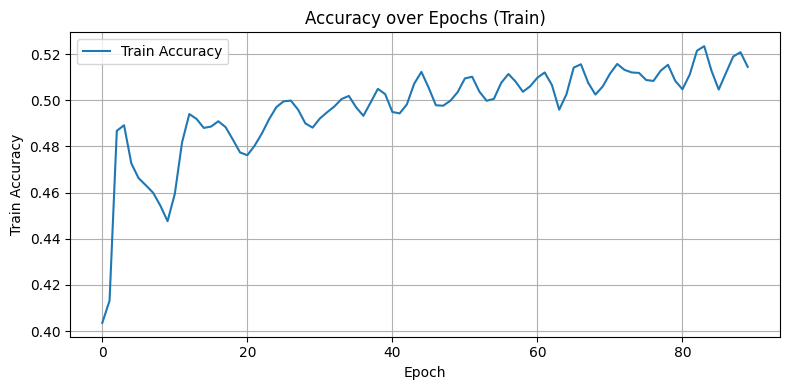

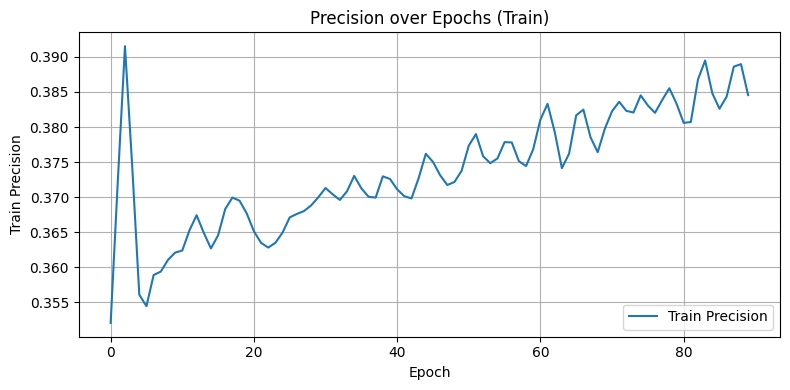

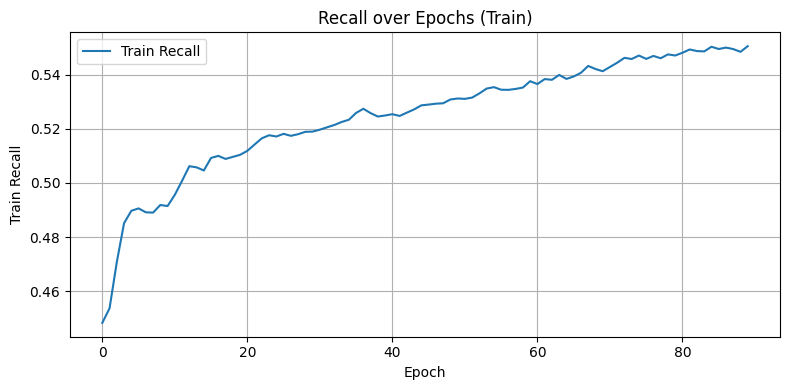

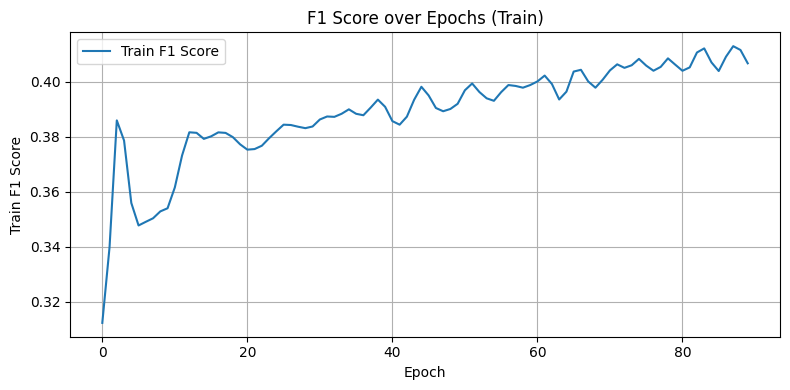

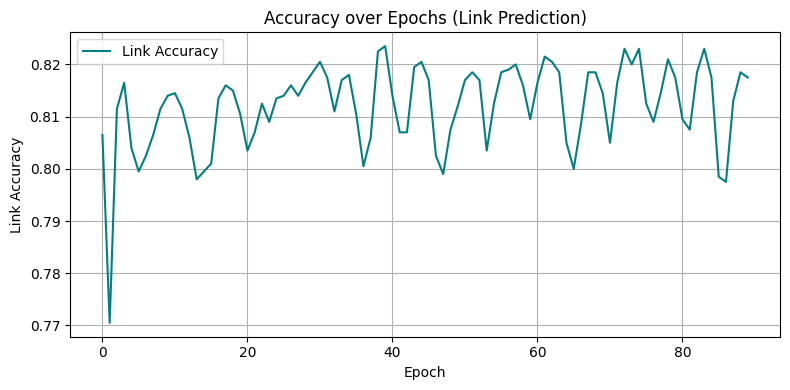

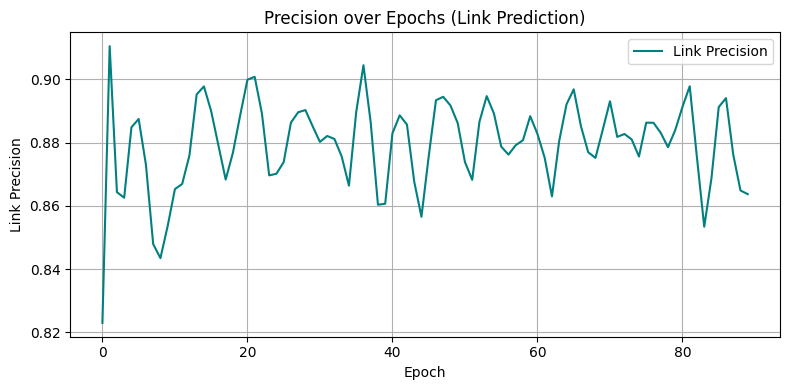

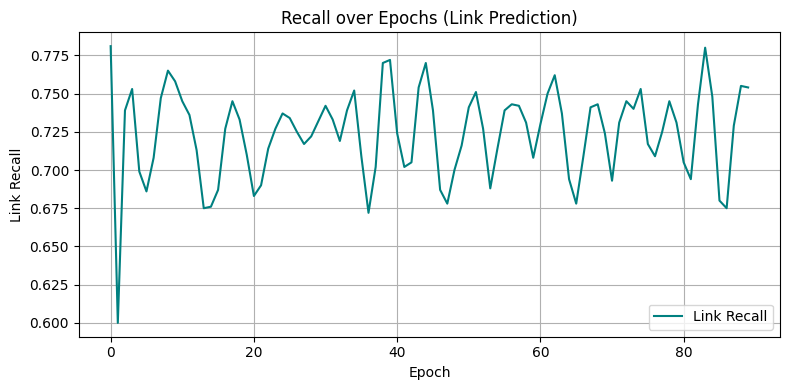

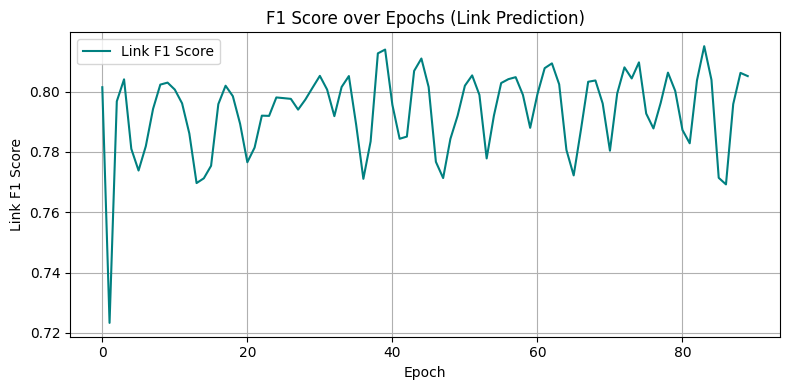

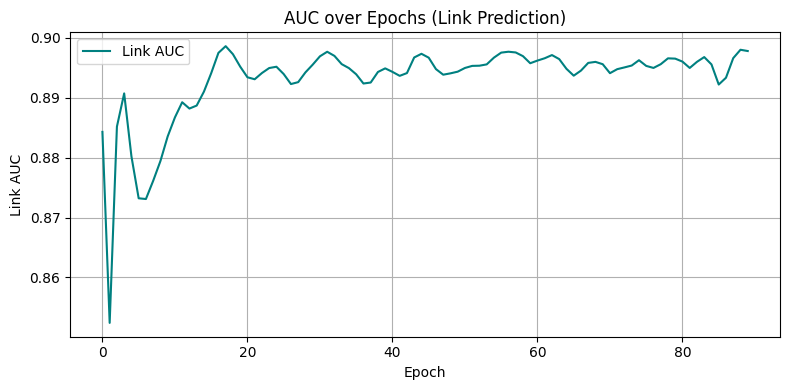

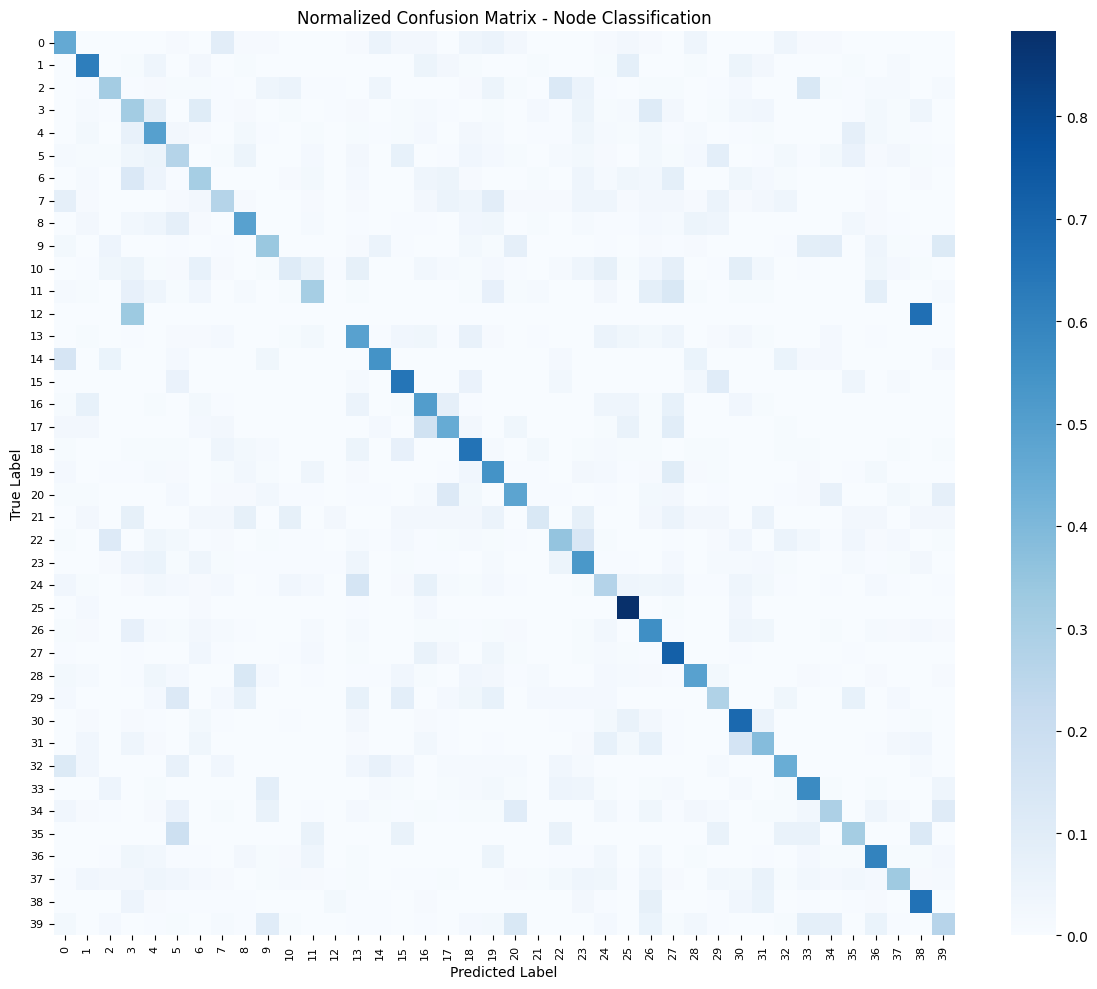

In [29]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import numpy as np

#loss plot
plt.figure(figsize=(10, 5))
plt.plot(all_node_losses, label="Node Classification Loss")
plt.plot(all_link_losses, label="Link Prediction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Head during Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#node classification - validation
import pandas as pd
import matplotlib.pyplot as plt


val_metrics = pd.read_csv("validation_metrics.csv")
train_metrics = pd.read_csv("training_metrics.csv")
link_metrics = pd.read_csv("link_metrics.csv")

def plot_metric(data, column, label, title, color=None):
    plt.plot(data["epoch"], data[column], label=label, color=color)
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.title(title)
    plt.legend()
    plt.grid(True)

val_metrics_map = {
    "val_accuracy": "Accuracy",
    "val_precision": "Precision",
    "val_recall": "Recall",
    "val_f1": "F1 Score",
    "val_auc": "AUC"
}

for col, name in val_metrics_map.items():
    plt.figure(figsize=(8, 4))
    plot_metric(val_metrics, col, f"Validation {name}", f"{name} over Epochs (Validation)")
    plt.tight_layout()
    plt.show()

#node classification - train
train_metrics_map = {
    "train_accuracy": "Accuracy",
    "train_precision": "Precision",
    "train_recall": "Recall",
    "train_f1": "F1 Score"
}

for col, name in train_metrics_map.items():
    plt.figure(figsize=(8, 4))
    plot_metric(train_metrics, col, f"Train {name}", f"{name} over Epochs (Train)")
    plt.tight_layout()
    plt.show()
#link prediction
link_metrics_map = {
    "link_accuracy": "Accuracy",
    "link_precision": "Precision",
    "link_recall": "Recall",
    "link_f1": "F1 Score",
    "link_auc": "AUC"
}

for col, name in link_metrics_map.items():
    plt.figure(figsize=(8, 4))
    plot_metric(link_metrics, col, f"Link {name}", f"{name} over Epochs (Link Prediction)", color="teal")
    plt.tight_layout()
    plt.show()
# confusion matrix
cm = confusion_matrix(y_true, y_pred)


cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)


plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, cmap="Blues", cbar=True)
plt.title("Normalized Confusion Matrix - Node Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

